In [29]:
import pandas as pd
from sklearn import datasets
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import os
import ast

from sklearn.decomposition import PCA
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

from helper import plot_missing_values, replace_ids_with_titles

In [30]:
# Import the datasets 
tracks_echonest = pd.read_csv('data/tracks_echonest_titles.tsv', sep='\t')
tracks_spectral = pd.read_csv('data/tracks_spectral_titles.tsv', sep='\t')
genres = pd.read_csv('data/genres.csv', sep=',')

# tracks_spectral['genres'] = tracks_spectral['genres'].apply(ast.literal_eval)
# tracks_spectral['genres_all'] = tracks_spectral['genres_all'].apply(ast.literal_eval)
# # transfor genre ids to titles
# tracks_spectral = replace_ids_with_titles(tracks_spectral, 'genre_top', genres)
# tracks_spectral = replace_ids_with_titles(tracks_spectral, 'genres', genres)
# tracks_spectral = replace_ids_with_titles(tracks_spectral, 'genres_all', genres)

/Users/aya/Supervised_Challenge/helper.py:29: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=na_pct.values, y=na_pct.index, palette='viridis')


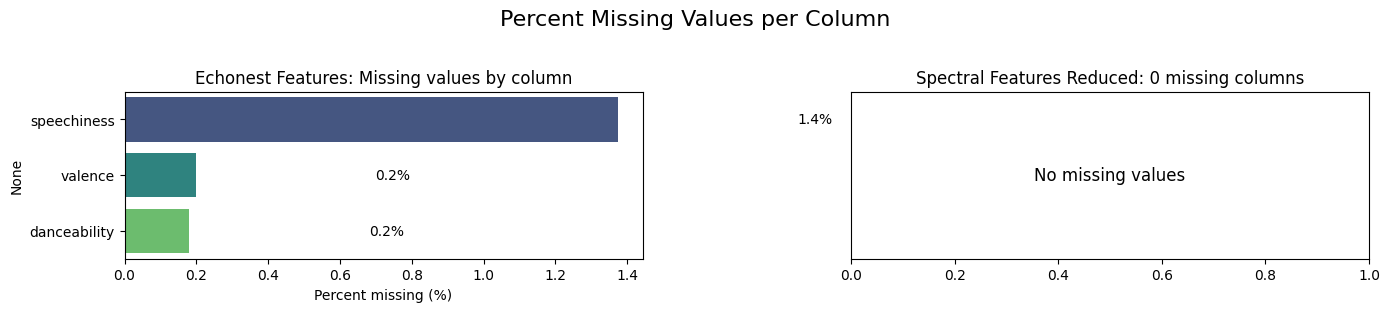

In [31]:
# Plot missing values in both datasets
datasets = {
    'Echonest Features': tracks_echonest,
    'Spectral Features Reduced': tracks_spectral
}

plot_missing_values(datasets)

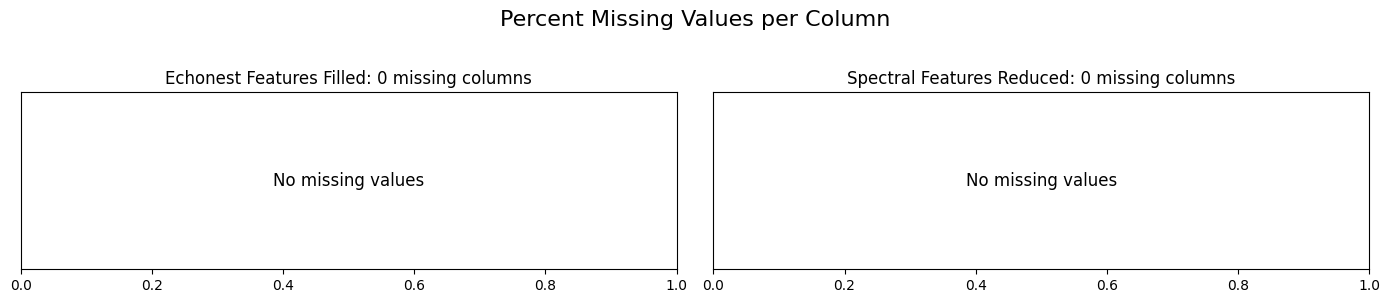

In [32]:
# remove missing values from tracks_echonest
df_spectral = tracks_spectral
df_echonest = tracks_echonest.dropna()
datasets = {
    'Echonest Features Filled': df_echonest,
    'Spectral Features Reduced': tracks_spectral
}
plot_missing_values(datasets)

In [33]:
print(f"Feature titles in tracks_echonest : {tracks_echonest.columns.tolist()}")

Feature titles in tracks_echonest : ['track_id', 'acousticness', 'danceability', 'energy', 'instrumentalness', 'liveness', 'speechiness', 'tempo', 'valence', 'album_title', 'album_tracks', 'artist_latitude', 'artist_longitude', 'artist_name', 'duration', 'favorites', 'genre_top', 'genres', 'genres_all', 'interest', 'listens', 'title', 'spectral_bandwidth_kurtosis_01', 'spectral_bandwidth_max_01', 'spectral_bandwidth_mean_01', 'spectral_bandwidth_median_01', 'spectral_bandwidth_min_01', 'spectral_bandwidth_skew_01', 'spectral_bandwidth_std_01', 'spectral_centroid_kurtosis_01', 'spectral_centroid_max_01', 'spectral_centroid_mean_01', 'spectral_centroid_median_01', 'spectral_centroid_min_01', 'spectral_centroid_skew_01', 'spectral_centroid_std_01', 'spectral_rolloff_kurtosis_01', 'spectral_rolloff_max_01', 'spectral_rolloff_mean_01', 'spectral_rolloff_median_01', 'spectral_rolloff_min_01', 'spectral_rolloff_skew_01', 'spectral_rolloff_std_01', 'artist_location_unknown']


## Feature Classification for Genre Prediction (Task 1 & 2)

### 1. ID / Join-Only Columns  
**Drop as predictors**
- `track_id` — use only for merges; never include as a feature.

---

### 2. High-Cardinality Text  
**Drop for baseline; maybe use later with NLP**
- `title`
- `album_title`
- `artist_name`

(Too sparse/high-cardinality for simple audio-only baselines.)

---

### 3. Genre Labels / Taxonomy  
**Targets or auxiliary info (not numeric predictors)**
- `genre_top` — **main target**
- `genres`, `genres_all` — lists of tags; can be parsed or merged with `genres.csv` but raw strings are unusable as features.

---

### 4. Core Audio Predictors  
**Keep — main baseline features**
- `acousticness`
- `danceability`
- `energy`
- `instrumentalness`
- `liveness`
- `speechiness`
- `tempo`
- `valence`
- `duration`

(Standard “Spotify-like” features; strong predictors for genre.)

---

### 5. Popularity / Usage  
**Keep *only* if predicting popularity — otherwise drop (genre leakage risk)**
- `favorites`
- `interest`
- `listens`

(These often correlate with genre distribution → leakage.)

---

### 6. Location / Context  
**Optional (weak signal for pure audio genre)**
- `artist_latitude`
- `artist_longitude`
- `artist_location_unknown`
- `album_tracks`

---

### 7. Spectral Feature Block  
**Keep, but ideally reduce dimensionality**
- All `spectral_bandwidth_*`
- All `spectral_centroid_*`
- All `spectral_rolloff_*`

(Important for timbre/brightness but highly redundant → PCA or aggregation recommended.)

---

### ✔ Recommended Clean Baseline Feature Set  
For a strong yet simple **genre prediction baseline**:
- The 8–9 Spotify-like audio features  
- `duration`  
- One location dummy (optional)  
- A **reduced set** of spectral features (via PCA or summary statistics)  
- **Drop** IDs, text fields, and popularity metrics


In [34]:
# Drop the ID columns
df_echonest = df_echonest.drop(columns=['track_id'])
df_spectral = df_spectral.drop(columns=['track_id'])

# Drop artist location related features
df_echonest = df_echonest.drop(columns=['artist_latitude', 'artist_longitude', 'artist_location_unknown'])
df_spectral = df_spectral.drop(columns=['artist_latitude', 'artist_longitude', 'artist_location_unknown'])

In [35]:
# We re going to inspect colinearity in these groups of features 
core_audio_features = ['danceability', 'energy', 'speechiness', 'acousticness', 'instrumentalness', 'liveness', 'valence', 'tempo', 'duration']
spectral_features = [col for col in df_spectral.columns if col.startswith('spectral_')]
popularity_features = ['favorites', 'interest', 'listens']

print(f"Core audio features: {core_audio_features}")
print(f"Spectral features: {spectral_features}")
print(f"Popularity features: {popularity_features}")
# print the rest of features execpt the above three groups
other_features = [col for col in df_echonest.columns if col not in core_audio_features + spectral_features + popularity_features]
print(f"Other features in df_echonest: {other_features}")
other_features_spectral = [col for col in df_spectral.columns if col not in core_audio_features + spectral_features + popularity_features]
print(f"Other features in df_spectral: {other_features_spectral}")

Core audio features: ['danceability', 'energy', 'speechiness', 'acousticness', 'instrumentalness', 'liveness', 'valence', 'tempo', 'duration']
Spectral features: ['spectral_bandwidth_kurtosis_01', 'spectral_bandwidth_max_01', 'spectral_bandwidth_mean_01', 'spectral_bandwidth_median_01', 'spectral_bandwidth_min_01', 'spectral_bandwidth_skew_01', 'spectral_bandwidth_std_01', 'spectral_centroid_kurtosis_01', 'spectral_centroid_max_01', 'spectral_centroid_mean_01', 'spectral_centroid_median_01', 'spectral_centroid_min_01', 'spectral_centroid_skew_01', 'spectral_centroid_std_01', 'spectral_rolloff_kurtosis_01', 'spectral_rolloff_max_01', 'spectral_rolloff_mean_01', 'spectral_rolloff_median_01', 'spectral_rolloff_min_01', 'spectral_rolloff_skew_01', 'spectral_rolloff_std_01']
Popularity features: ['favorites', 'interest', 'listens']
Other features in df_echonest: ['album_title', 'album_tracks', 'artist_name', 'genre_top', 'genres', 'genres_all', 'title']
Other features in df_spectral: ['albu

In [36]:
def plot_feature_correlation(df, feature_list, title="Correlation Matrix"):
    """
    Plots a correlation matrix for a given list of features in a DataFrame.

    Parameters:
        df (pd.DataFrame): DataFrame containing the features.
        feature_list (list): List of column names to include in the correlation matrix.
        title (str): Title of the plot.
    """
    corr = df[feature_list].corr()
    plt.figure(figsize=(10, 8))
    sns.heatmap(corr, annot=False, fmt=".1f", cmap="coolwarm", square=True, linewidths=0.5)
    plt.title(title, fontsize=16)
    plt.show()

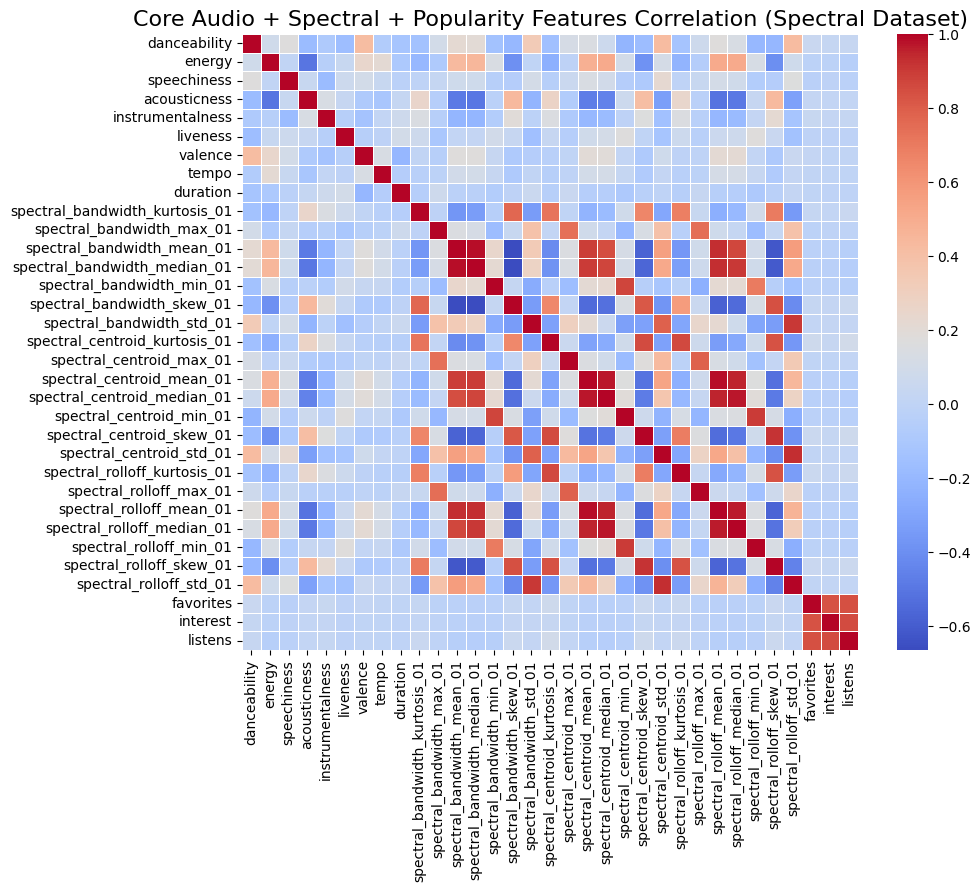

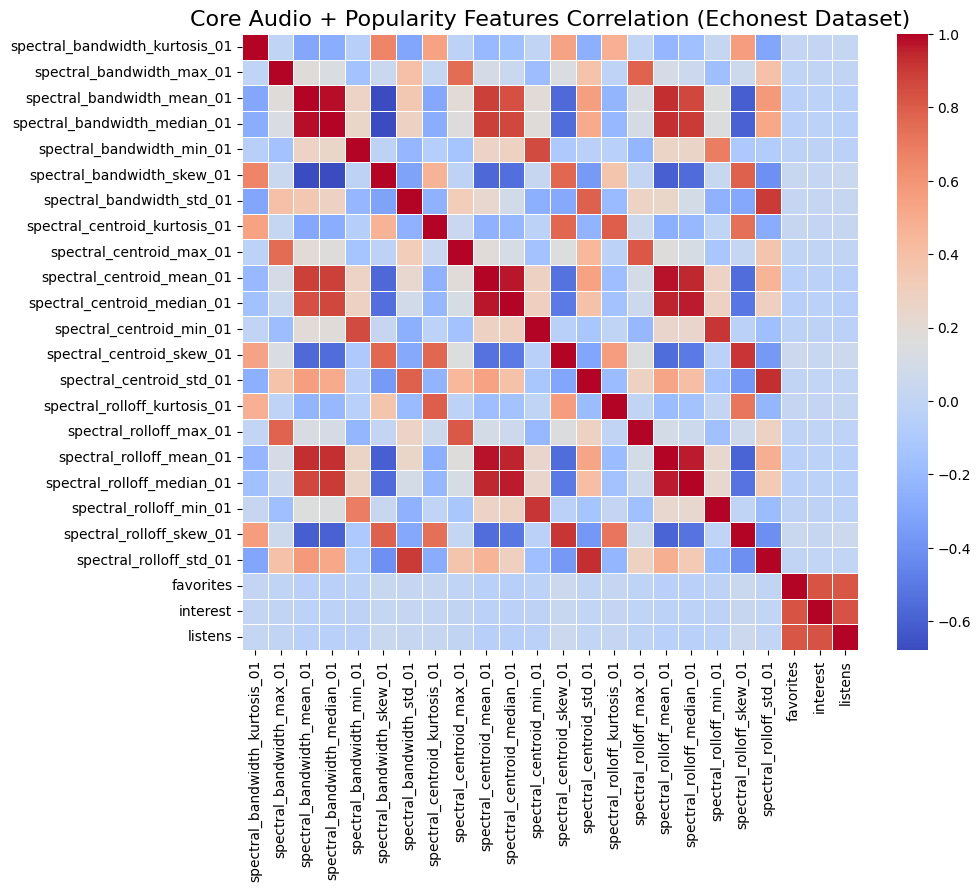

In [37]:
plot_feature_correlation(df_echonest, core_audio_features+spectral_features+popularity_features, title="Core Audio + Spectral + Popularity Features Correlation (Spectral Dataset)")
plot_feature_correlation(df_spectral, spectral_features+popularity_features, title="Core Audio + Popularity Features Correlation (Echonest Dataset)")

In [38]:
# We will use PCA on spectral features to reduce colinearity

def apply_pca(df, feature_list, n_components=None):
    """
    Applies PCA to a group of features.

    Parameters:
        df (pd.DataFrame): DataFrame containing the features.
        feature_list (list): List of columns to apply PCA on.
        n_components (int or None): Number of PCA components to keep. If None, keep all.

    Returns:
        pca (PCA object): Fitted PCA object.
        df_pca (pd.DataFrame): Transformed PCA components as DataFrame.
    """
    pca = PCA(n_components=n_components)
    X = df[feature_list].values
    X_pca = pca.fit_transform(X)
    
    # Build a DataFrame with PCA components
    component_names = [f"PC{i+1}" for i in range(X_pca.shape[1])]
    df_pca = pd.DataFrame(X_pca, columns=component_names, index=df.index)
    
    return pca, df_pca

def plot_pca_correlations(df, feature_list, pca, df_pca, title="PCA vs Original Features Correlation"):
    """
    Plots correlation of each PCA component with the original features.

    Parameters:
        df (pd.DataFrame): Original DataFrame.
        feature_list (list): Original features used in PCA.
        pca (PCA object): Fitted PCA object.
        df_pca (pd.DataFrame): DataFrame containing PCA components.
        title (str): Title of the plot.
    """
    # Compute correlation of each PCA component with original features
    corr_matrix = pd.DataFrame(
        np.dot(df[feature_list].values.T, df_pca.values) / (len(df)-1),
        index=feature_list,
        columns=df_pca.columns
    )
    
    # Optional: normalize correlations between -1 and 1
    corr_matrix = corr_matrix / corr_matrix.abs().max()
    
    plt.figure(figsize=(12,8))
    sns.heatmap(corr_matrix, annot=False, cmap="coolwarm", fmt=".2f", linewidths=0.5)
    plt.title(title, fontsize=16)
    plt.show()

def plot_pca_variance(pca, title="Explained Variance per PCA Component"):
    """
    Plots the explained variance ratio of each PCA component.

    Parameters:
        pca (PCA object): Fitted PCA object.
        title (str): Title of the plot.
    """
    explained_variance = pca.explained_variance_ratio_
    cumulative_variance = explained_variance.cumsum()
    
    plt.figure(figsize=(10,6))
    plt.bar(range(1, len(explained_variance)+1), explained_variance, alpha=0.6, label="Individual variance")
    plt.step(range(1, len(cumulative_variance)+1), cumulative_variance, where='mid', color='red', label="Cumulative variance")
    plt.xlabel("PCA Component")
    plt.ylabel("Explained Variance Ratio")
    plt.title(title, fontsize=16)
    plt.xticks(range(1, len(explained_variance)+1))
    plt.legend()
    plt.show()




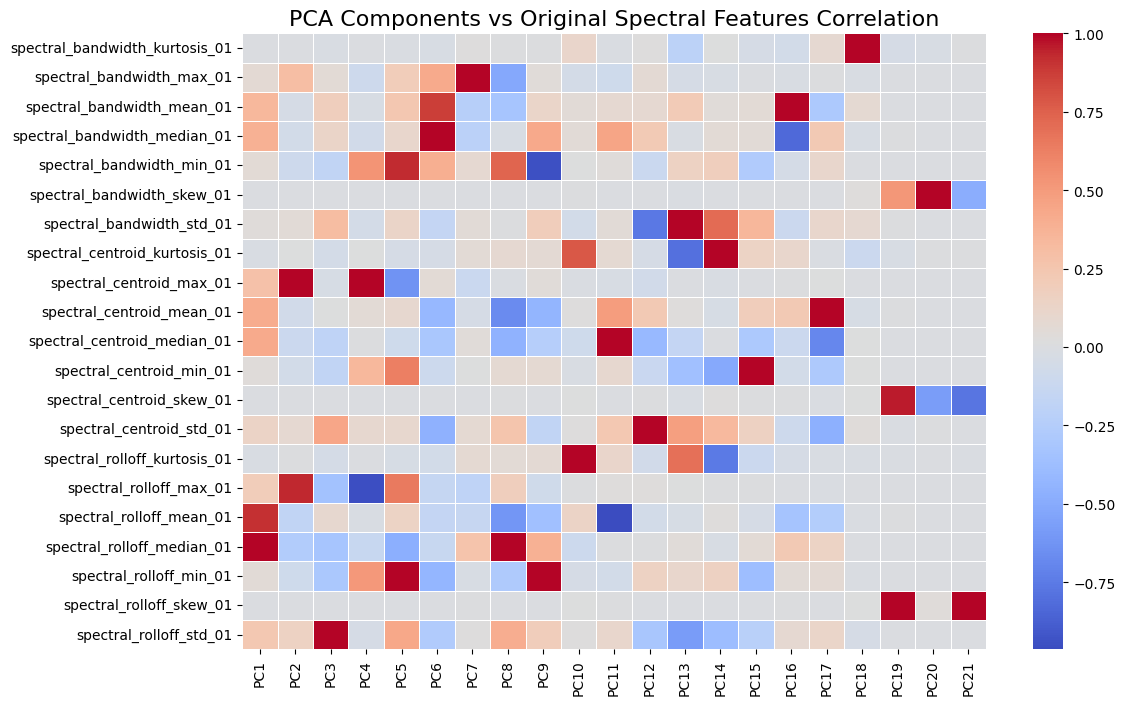

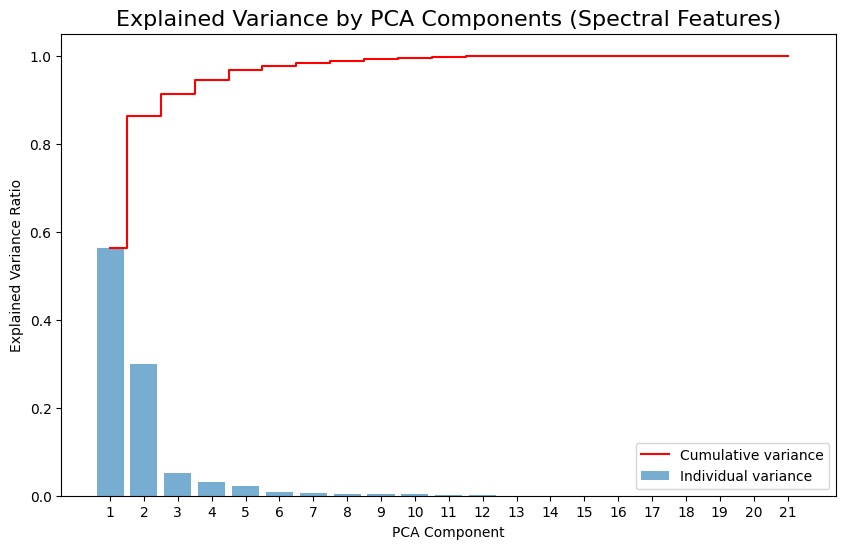

In [39]:
pca_spectral, df_pca_spectral = apply_pca(df_spectral, spectral_features)
plot_pca_correlations(df_spectral, spectral_features, pca_spectral, df_pca_spectral, title="PCA Components vs Original Spectral Features Correlation")
plot_pca_variance(pca_spectral, title="Explained Variance by PCA Components (Spectral Features)")

In [40]:
# We re going to keep the 1st 5 PCA components and remove all spectral original features
n_pca_components = 5
df_spectral_pca = df_spectral.drop(columns=spectral_features)
df_echonest_pca = df_echonest.drop(columns=spectral_features)
for i in range(n_pca_components):
    df_spectral_pca[f'Spec_PC{i+1}'] = df_pca_spectral[f'PC{i+1}']
    df_echonest_pca[f'Spec_PC{i+1}'] = df_pca_spectral[f'PC{i+1}']


print(f"DataFrame shape after adding PCA components: {df_spectral_pca.shape}")
print(f"Dataframe features after adding PCA components: {df_spectral_pca.columns.tolist()}")
print(f"DataFrame shape after adding PCA components: {df_echonest_pca.shape}")
print(f"Dataframe features after adding PCA components: {df_echonest_pca.columns.tolist()}")

DataFrame shape after adding PCA components: (97288, 16)
Dataframe features after adding PCA components: ['album_title', 'album_tracks', 'artist_name', 'duration', 'favorites', 'genre_top', 'genres', 'genres_all', 'interest', 'listens', 'title', 'Spec_PC1', 'Spec_PC2', 'Spec_PC3', 'Spec_PC4', 'Spec_PC5']
DataFrame shape after adding PCA components: (10405, 24)
Dataframe features after adding PCA components: ['acousticness', 'danceability', 'energy', 'instrumentalness', 'liveness', 'speechiness', 'tempo', 'valence', 'album_title', 'album_tracks', 'artist_name', 'duration', 'favorites', 'genre_top', 'genres', 'genres_all', 'interest', 'listens', 'title', 'Spec_PC1', 'Spec_PC2', 'Spec_PC3', 'Spec_PC4', 'Spec_PC5']


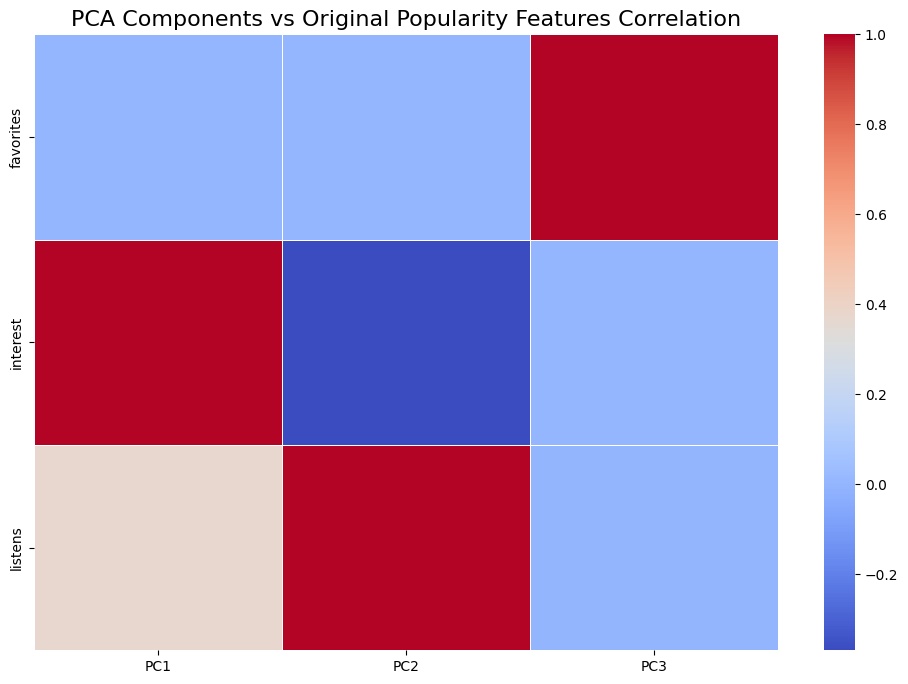

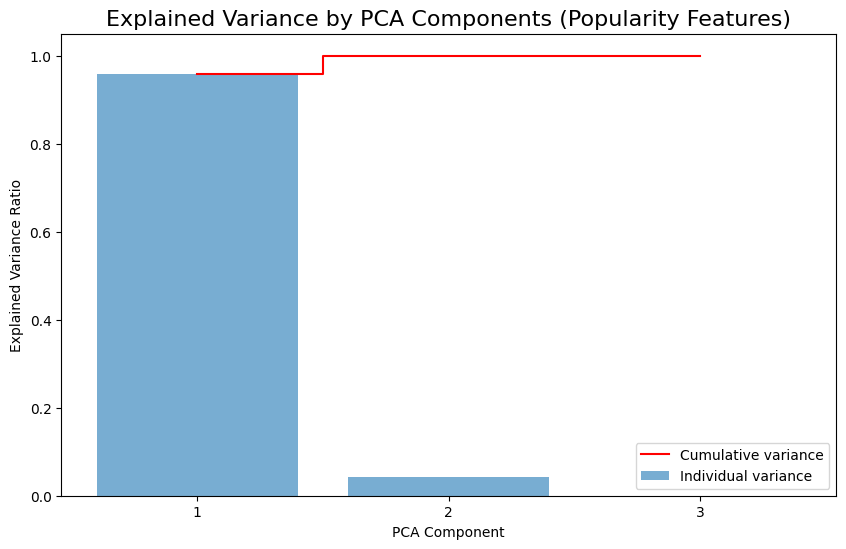

In [41]:
# Apply PCA on popularity features as well 
pca_popularity, df_pca_popularity = apply_pca(df_spectral_pca, popularity_features)
plot_pca_correlations(df_spectral_pca, popularity_features, pca_popularity, df_pca_popularity, title="PCA Components vs Original Popularity Features Correlation")
plot_pca_variance(pca_popularity, title="Explained Variance by PCA Components (Popularity Features)")

In [42]:
# We are going to keep only the 1st pca component from popularity features
# for both datasets
n_popularity_pca_components = 1
df_spectral_final = df_spectral_pca.drop(columns=popularity_features)
df_echonest_final = df_echonest_pca.drop(columns=popularity_features)
for i in range(n_popularity_pca_components):
    df_spectral_final[f'Pop_PC{i+1}'] = df_pca_popularity[f'PC{i+1}']
    df_echonest_final[f'Pop_PC{i+1}'] = df_pca_popularity[f'PC{i+1}']

print(f"DataFrame shape after adding PCA components: {df_spectral_final.shape}")
print(f"Dataframe features after adding PCA components: {df_spectral_final.columns.tolist()}")
print(f"DataFrame shape after adding PCA components: {df_echonest_final.shape}")
print(f"Dataframe features after adding PCA components: {df_echonest_final.columns.tolist()}")

DataFrame shape after adding PCA components: (97288, 14)
Dataframe features after adding PCA components: ['album_title', 'album_tracks', 'artist_name', 'duration', 'genre_top', 'genres', 'genres_all', 'title', 'Spec_PC1', 'Spec_PC2', 'Spec_PC3', 'Spec_PC4', 'Spec_PC5', 'Pop_PC1']
DataFrame shape after adding PCA components: (10405, 22)
Dataframe features after adding PCA components: ['acousticness', 'danceability', 'energy', 'instrumentalness', 'liveness', 'speechiness', 'tempo', 'valence', 'album_title', 'album_tracks', 'artist_name', 'duration', 'genre_top', 'genres', 'genres_all', 'title', 'Spec_PC1', 'Spec_PC2', 'Spec_PC3', 'Spec_PC4', 'Spec_PC5', 'Pop_PC1']
